In [7]:
import sys
import datacube
import numpy as np
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles


sys.path.append('../../Scripts')
from dea_datahandling import load_ard
from dea_datahandling import mostcommon_crs
from dea_dask import create_local_dask_cluster
from dea_plotting import xr_animation
from dea_coastaltools import tidal_tag

dc = datacube.Datacube(app='Animated timeseries' )


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from odc.ui import select_on_a_map
from ipyleaflet import basemaps, basemap_to_tiles

# Plot interactive map to select area
basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
geopolygon = select_on_a_map(height='600px',
                             layers=(basemap,),
                             center=(-26, 135), 
                             zoom=4) 

Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map …

In [ ]:
bands=['nbar_red', 'nbar_green', 'nbar_blue']
# bands=['nbar_swir_1', 'nbar_nir', 'nbar_green']

# Configure local dask cluster
create_local_dask_cluster()

# Obtain native CRS 
crs = mostcommon_crs(dc=dc, 
                     product='ga_ls5t_ard_3', 
                     query={'time': '1990', 
                            'geopolygon': geopolygon})

query = {
    'geopolygon': geopolygon,
    'time': ('1987', '2020'),
    'measurements': bands,
    'resampling': {'fmask': 'nearest', 
                   'oa_fmask': 'nearest', 
                   '*': 'nearest'},
    'output_crs': crs,
    'resolution': (-30, 30),
    'group_by': 'solar_day',
    'dask_chunks': {'time': 1, 'x': 2000, 'y': 2000}
}

ds_ls = load_ard(dc=dc,
                 products=[
                           'ga_ls5t_ard_3', 'ga_ls7e_ard_3', 'ga_ls8c_ard_3', 
#                            'ga_s2a_ard_nbar_granule', 'ga_s2b_ard_nbar_granule', 
#                            's2a_nrt_granule', 's2b_nrt_granule'
                          ],
                 min_gooddata=0.9,
                 ls7_slc_off=False,
                 mask_pixel_quality=True,
                 **query)


ds_ls = tidal_tag(ds_ls)
ds_ls = ds_ls.sel(time = ds_ls.tide_height < ds_ls.tide_height.median())
ds_ls = ds_ls.compute()
ds_ls


# dss_ls5 = dc.find_datasets(product='ls5_nbart_geomedian_annual', **query)
# dss_ls7 = dc.find_datasets(product='ls7_nbart_geomedian_annual', **query)
# dss_ls8 = dc.find_datasets(product='ls8_nbart_geomedian_annual', **query)
# dss = dss_ls5 + dss_ls7 + dss_ls8

# ds = dc.load(datasets=dss,
#              measurements=['red', 'green', 'blue'],
#              output_crs='EPSG:3577',
#              resolution=(-30, 30),
#              **query)
# ds


/env/lib/python3.6/site-packages/distributed/dashboard/core.py:72: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)


Client Scheduler: tcp://127.0.0.1:43471 Dashboard: /user/robbibt/proxy/35941/status,Cluster Workers: 1 Cores: 2 Memory: 14.18 GB


In [ ]:
ds_rolling = ds_ls.rolling(time=20, center=True, min_periods=1).median()
median_array = np.transpose(ds_rolling[bands]
                            .median(dim='time')
                            .to_array().values, 
                            axes=(1, 2, 0))
ds_rolling

In [252]:
# import geopandas as gpd
# import pandas as pd
# import matplotlib

# overlay_gdf = gpd.read_file('example2.geojson')
# overlay_gdf = overlay_gdf.dissolve('year')

# norm = matplotlib.colors.Normalize(vmin=0, vmax=len(overlay_gdf.index))
# cmap = matplotlib.cm.get_cmap('YlOrRd')
# rgba = cmap(norm(overlay_gdf.reset_index().index))
# overlay_gdf['color'] = list(rgba)
# overlay_gdf['start_time'] = pd.to_datetime(overlay_gdf.index) 
# overlay_gdf.head()

,geometry,color,start_time
year,,,
1988,"MULTILINESTRING ((1697223.193 -3062203.974, 16...","[1.0, 1.0, 0.8, 1.0]",1988-01-01
1989,"MULTILINESTRING ((1697253.965 -3062202.984, 16...","[1.0, 0.9822837370242214, 0.7566935793925413, ...",1989-01-01
1990,"MULTILINESTRING ((1697239.897 -3062204.047, 16...","[1.0, 0.9645674740484429, 0.7133871587850826, ...",1990-01-01
1991,"MULTILINESTRING ((1697253.935 -3062203.293, 16...","[1.0, 0.9468512110726643, 0.670080738177624, 1.0]",1991-01-01
1992,"MULTILINESTRING ((1697253.846 -3062204.215, 16...","[0.9998615916955017, 0.926643598615917, 0.6216...",1992-01-01


Applying custom image processing functions


Exporting animation to animation.mp4


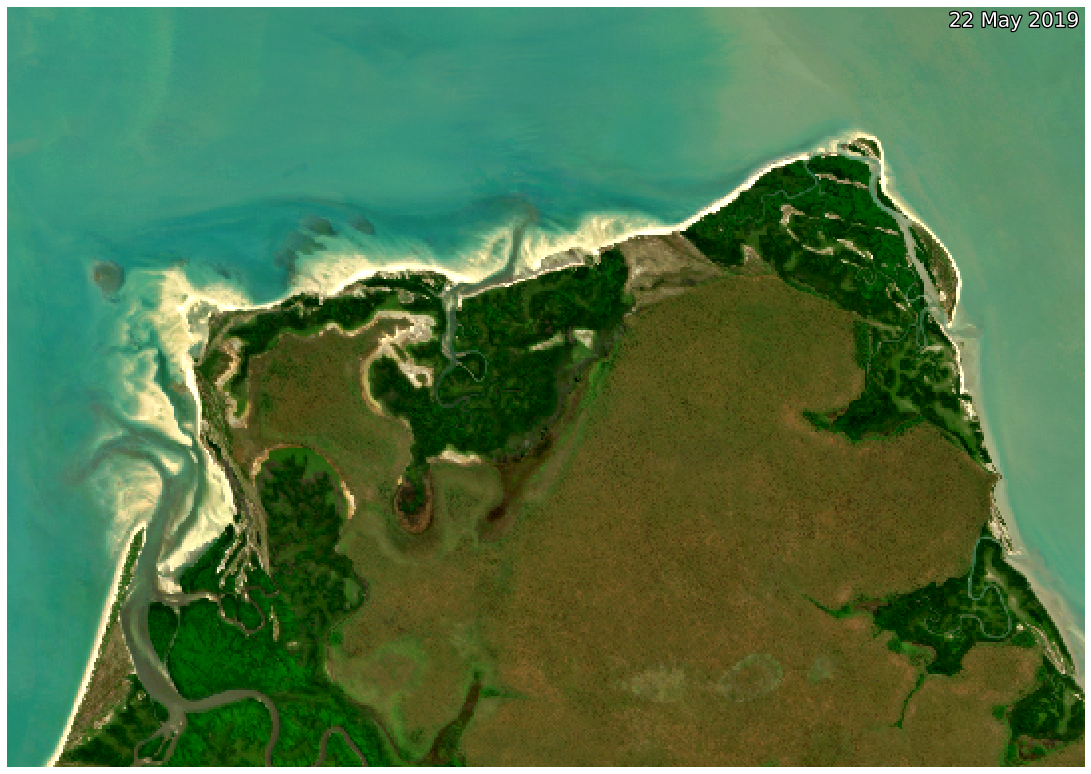

In [50]:
import numpy as np
from skimage.color import rgb2hsv, hsv2rgb
from skimage.filters import unsharp_mask
from skimage.exposure import match_histograms, rescale_intensity

funcs_list = [lambda x: match_histograms(image=x, reference=median_array, multichannel=True),
              lambda x: x**0.15,
              rescale_intensity,
              lambda x: unsharp_mask(x, radius=50, amount=0.5),
              lambda x: unsharp_mask(x, radius=5, amount=0.2)]
# funcs_list = None

xr_animation(ds=ds_rolling.isel(time=slice(5, -5)),
             bands=bands,
             interval=60,
             width_pixels=1080,
             percentile_stretch=(0.01, 0.995),
             image_proc_funcs=funcs_list,
#              limit=10,
            ) 